To open on Google Colab [link](https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week8/intro_rdkit.ipynb)

In [ ]:
!pip install rdkit-pypi
!pip install avogadro
!pip install py3Dmol


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Draw import IPythonConsole

import networkx as nx

IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

# Introduction to ChemiInformatics
(Reference: [**Book**](https://link.springer.com/book/10.1007/978-1-4020-6291-9))

Goals: 
1. **How do we store information about a chemical structure in a computer?**
2. Introduction to [RDKit](https://www.rdkit.org/docs/index.html).

## Molecular graphs

Molecules can be represented as *Graphs* where,\
> **nodes** contains the information of the atoms -> atomic number of atom type \
> **edges** represents the connectivity -> bond order or type

**A graph represents the topology of our molecule!**\
(topology -> connectivity)

## SMILES
The **simplified molecular-input line-entry system** (SMILES) is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings. 

The SMILES description is based on,
1. Atoms ```[Co+3]```
2. Bonds ```. - = # $ : / \``` 
   1. ```.``` no bonds ```[Na+].[Cl-]```
   2. ```- = # $``` are single, double, triple, quadruple
   3. ```:``` "one and a half" bond
   4.  ```/``` or ```\``` to indicate stereochemical configuration)
3. Rings
   * cyclopropene is usually written ```C1=CC1```
4. Branching
   * It uses ```()``` 

from [Wikipedia](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)

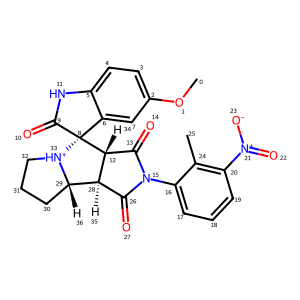

In [3]:
# caff_sm = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
m = AllChem.MolFromSmiles(caff_sm)
m

SMILES usually avoid the notation with ```H``` to reduce the string length.
However, one could add them in RDKiT.

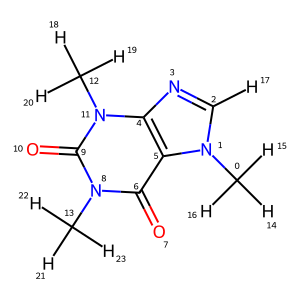

In [20]:
m_wH = Chem.rdmolops.AddHs(m)
m_wH

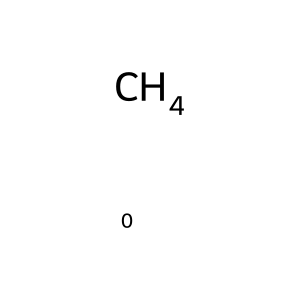

In [21]:
water_sm = 'C'
m = AllChem.MolFromSmiles(water_sm)
m

## canonical SMILES
RDKit a canonicalization algorithm uses rules to produce a unique ordering for the atoms

**Aspirin**: O=C(C)Oc1ccccc1C(=O)O \
(from [Wikipedia](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwitk7DA5839AhXYkIkEHa0dDrgQFnoECA8QAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FAspirin&usg=AOvVaw02IeN5OW-BJ2TIBNLoNsgI))

<img src="https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/Canonical-a-and-randomized-b-SMILES-representations-of-aspirin-Randomized-SMILES.png"  width="600" height="300">


In [5]:
molec_smiles = "O=C(C)Oc1ccccc1C(=O)O" #'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'  # 'OCCC'
molecule = AllChem.MolFromSmiles(molec_smiles)
unique_smiles = AllChem.MolToSmiles(molecule, canonical=True)
print(molec_smiles)
print(unique_smiles)

O=C(C)Oc1ccccc1C(=O)O
CC(=O)Oc1ccccc1C(=O)O


In [32]:

molec_smiles =  'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
mol = AllChem.MolFromSmiles(molec_smiles)

atoms = mol.GetAtoms()
n_atoms = mol.GetNumAtoms()
atoms_list = [a.GetSymbol() for a in atoms]
A = GetAdjacencyMatrix(mol)

print(n_atoms)
print(atoms_list)
# print(A)

# assert 0
(rows, cols) = np.nonzero(A)
for (k, (i, j)) in enumerate(zip(rows, cols)):
  bond = mol.GetBondBetweenAtoms(int(i), int(j))
  print(i, j, atoms_list[int(i)], atoms_list[int(j)], bond.GetBondType())
  # permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
  # bond_type_enc = np.one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)


14
['C', 'N', 'C', 'N', 'C', 'C', 'C', 'O', 'N', 'C', 'O', 'N', 'C', 'C']
0 1 C N SINGLE
1 0 N C SINGLE
1 2 N C AROMATIC
1 5 N C AROMATIC
2 1 C N AROMATIC
2 3 C N AROMATIC
3 2 N C AROMATIC
3 4 N C AROMATIC
4 3 C N AROMATIC
4 5 C C AROMATIC
4 11 C N AROMATIC
5 1 C N AROMATIC
5 4 C C AROMATIC
5 6 C C AROMATIC
6 5 C C AROMATIC
6 7 C O DOUBLE
6 8 C N AROMATIC
7 6 O C DOUBLE
8 6 N C AROMATIC
8 9 N C AROMATIC
8 13 N C SINGLE
9 8 C N AROMATIC
9 10 C O DOUBLE
9 11 C N AROMATIC
10 9 O C DOUBLE
11 4 N C AROMATIC
11 9 N C AROMATIC
11 12 N C SINGLE
12 11 C N SINGLE
13 8 C N SINGLE


In [33]:
# print(' ',[print(a) for a in atoms])
# for i,(ai,a) in enumerate(zip(atoms,A)):
for i in range(len(atoms_list)+1):
  if i == 0:
    print('   ', end=' ')
    for j, ai in enumerate(atoms_list):
      print('%s:%s' % (ai, j), end=' ')
  else:
    j = i-1
    print('%s:%s ' % (atoms_list[j], j), end=' ')
    for jj, ami in enumerate(A[j]):
      if jj < 11:
        print(' %s ' % (ami), end=' ')
      else:
        print(' %s  ' % (ami), end=' ')
  print('\n')



    C:0 N:1 C:2 N:3 C:4 C:5 C:6 O:7 N:8 C:9 O:10 N:11 C:12 C:13 

C:0   0   1   0   0   0   0   0   0   0   0   0   0    0    0   

N:1   1   0   1   0   0   1   0   0   0   0   0   0    0    0   

C:2   0   1   0   1   0   0   0   0   0   0   0   0    0    0   

N:3   0   0   1   0   1   0   0   0   0   0   0   0    0    0   

C:4   0   0   0   1   0   1   0   0   0   0   0   1    0    0   

C:5   0   1   0   0   1   0   1   0   0   0   0   0    0    0   

C:6   0   0   0   0   0   1   0   1   1   0   0   0    0    0   

O:7   0   0   0   0   0   0   1   0   0   0   0   0    0    0   

N:8   0   0   0   0   0   0   1   0   0   1   0   0    0    1   

C:9   0   0   0   0   0   0   0   0   1   0   1   1    0    0   

O:10   0   0   0   0   0   0   0   0   0   1   0   0    0    0   

N:11   0   0   0   0   1   0   0   0   0   1   0   0    1    0   

C:12   0   0   0   0   0   0   0   0   0   0   0   1    0    0   

C:13   0   0   0   0   0   0   0   0   1   0   0   0    0    0   



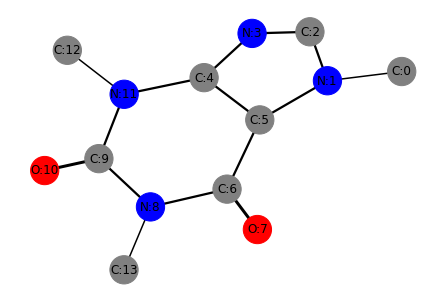

In [118]:
# define the function for coverting rdkit object to networkx object -----------
def molecular_graph(mol):
    
    # core function to construct a molecular graph
    def mol_to_nx(mol):
        G = nx.Graph()

        for atom in mol.GetAtoms():
            
            G.add_node(atom.GetIdx(),
                    atomic_num=atom.GetAtomicNum(),
                    is_aromatic=atom.GetIsAromatic(),
                    atom_symbol=atom.GetSymbol())

        for bond in mol.GetBonds():
            # bt = bond.GetBondType()
            bt = bond.GetBondTypeAsDouble()
            # bt = bt['bond_type']
            G.add_edge(bond.GetBeginAtomIdx(),
                    bond.GetEndAtomIdx(),
                    bond_type=bt,
                    weight=1.5*bt)

        return G

    # conver rdkit object to networkx object 
    mol_nx = mol_to_nx(mol)

    mol_atom = nx.get_node_attributes(mol_nx, 'atom_symbol')
    mol_atom_w_indx = mol_atom.copy()
    for i,k in enumerate(mol_atom_w_indx):
        mol_atom_w_indx[k] = '%s:%s'%(mol_atom[i],i)

    color_map = {'C': 'grey',
                'O': 'red',
                'N': 'blue',
                'H': 'white',
                }

    mol_colors = []
    for idx in mol_nx.nodes():
        if (mol_nx.nodes[idx]['atom_symbol'] in color_map):
            mol_colors.append(
                color_map[mol_nx.nodes[idx]['atom_symbol']])
        else:
            mol_colors.append('gray')
    
    edge_weight = []
    bond_types_str = ['SINGLE', 'DOUBLE','TRIPLE', 'AROMATIC']

    edges = mol_nx.edges()
    weights = [mol_nx[u][v]['weight'] for u, v in edges]
    nx.draw(mol_nx,
            labels=mol_atom_w_indx,
            with_labels=True,
            node_color=mol_colors,
            width=weights,
            node_size=800)

    plt.show()

caff_sm = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
mol = AllChem.MolFromSmiles(caff_sm)
# mol_wH = Chem.rdmolops.AddHs(mol)
molecular_graph(mol)

